In [61]:
# data generator

import tensorflow as tf
import numpy as np
import cv2

## for augmentation
def adjust_gamma(image, gamma=1.9, rotation_angle=0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(0, 256)], dtype=np.uint8)
    gamma_corrected = cv2.LUT(image, table)
    rotated_image = rotate_image(gamma_corrected, rotation_angle)
    return rotated_image

def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return rotated_image


def change_hue_chroma_lightness(image, hue_offset=0, chroma_scale=1.0, lightness_scale=1.0):

    # # Convert BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Split the HSV channels
    h, s, v = cv2.split(hsv_image)


    # Apply the hue offset
    h = (h + hue_offset) % 180

    # Scale the chroma (saturation) and lightness
    s = np.clip(np.round(s * chroma_scale), 0, 255).astype(np.uint8)
    v = np.clip(np.round(v * lightness_scale), 0, 255).astype(np.uint8)

    # Merge the modified HSV channels
    modified_hsv = cv2.merge((h, s, v))

    # Convert back to BGR color space
    modified_bgr = cv2.cvtColor(modified_hsv, cv2.COLOR_HSV2BGR)

    return modified_bgr

def adjust_color_balance(image, cyan_red, magenta_green, yellow_blue):
    # Split the image into its RGB channels
    blue, green, red = cv2.split(image)

    # Apply color adjustments for each channel
    red = np.clip(red + cyan_red, 0, 255).astype(np.uint8)
    green = np.clip(green + magenta_green, 0, 255).astype(np.uint8)
    blue = np.clip(blue + yellow_blue, 0, 255).astype(np.uint8)

    # Merge the adjusted channels back into a single image
    adjusted_image = cv2.merge([blue, green, red])

    return adjusted_image

def threshold_pixel(pixel_value, threshold_value):
    return pixel_value < threshold_value

def flip_horizontal(image):
    return cv2.flip(image, 1)  # 1 means flipping around y-axis


class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, StartingPositions, Gts):
        self.StartingPositions = StartingPositions
        self.Gts = Gts
        self.batch_size = 8

####### ****  The overall batchsize will be 8 times this number above, due to augmentation

    def __len__(self):
        return int(len(self.StartingPositions) / self.batch_size)

    def __getitem__(self, index):
        batch_addresses = self.StartingPositions[index * self.batch_size:(index + 1) * self.batch_size]

        batch_labels = self.Gts[index * self.batch_size:(index + 1) * self.batch_size]

        patch_batch_images = np.empty(((self.batch_size*8, *(256,256), 3)))
        labels_batch = np.empty((self.batch_size*8), dtype=int)


        for ndex, address in enumerate(batch_addresses):
            images = load_patch(address[3], address[4], address[0],3,256)
            # print('shape: ', image.shape)
            patch = images
            gammas = [1, 0.3, 0.7, 1.8, 1.1, 0.4, 0.8, 1.9]
            angles = [90, 180, 0, 270, 90, 180, 0, 270]
            flips = [False, False, False, False, True, True, True, True]
            augment_hues = [
                [[0,1,1],[0,0,0]], [[0,1,1],[0,0,0]], [[0,1.2,1.1],[0,-10,0]], [[0,0.5,0.9],[0,-10,0]],
                [[0,0.8,1.2],[0,-7,0]], [[0,1.1,0.5],[0,6,0.3]], [[0,0.3,1],[0,0.2,0.2]], [[0,1.6,0.95],[0.2,5,4]]
            ]

            for i in range(8):
                image_gm3 = adjust_gamma(patch, gammas[i], angles[i])
                img_cont3 = image_gm3.copy()
                img_cont3 = change_hue_chroma_lightness(img_cont3, hue_offset=augment_hues[i][0][0], chroma_scale=augment_hues[i][0][1], lightness_scale=augment_hues[i][0][2])
                adjusted_image3 = adjust_color_balance(img_cont3, augment_hues[i][1][0], augment_hues[i][1][1], augment_hues[i][1][2])

                # Apply horizontal flipping based on the flips list
                if flips[i]:
                    adjusted_image3 = flip_horizontal(adjusted_image3)

                patch_batch_images[ndex * 8 + i] = adjusted_image3
                labels_batch[ndex * 8 + i] = batch_labels[ndex]

            return patch_batch_images, labels_batch



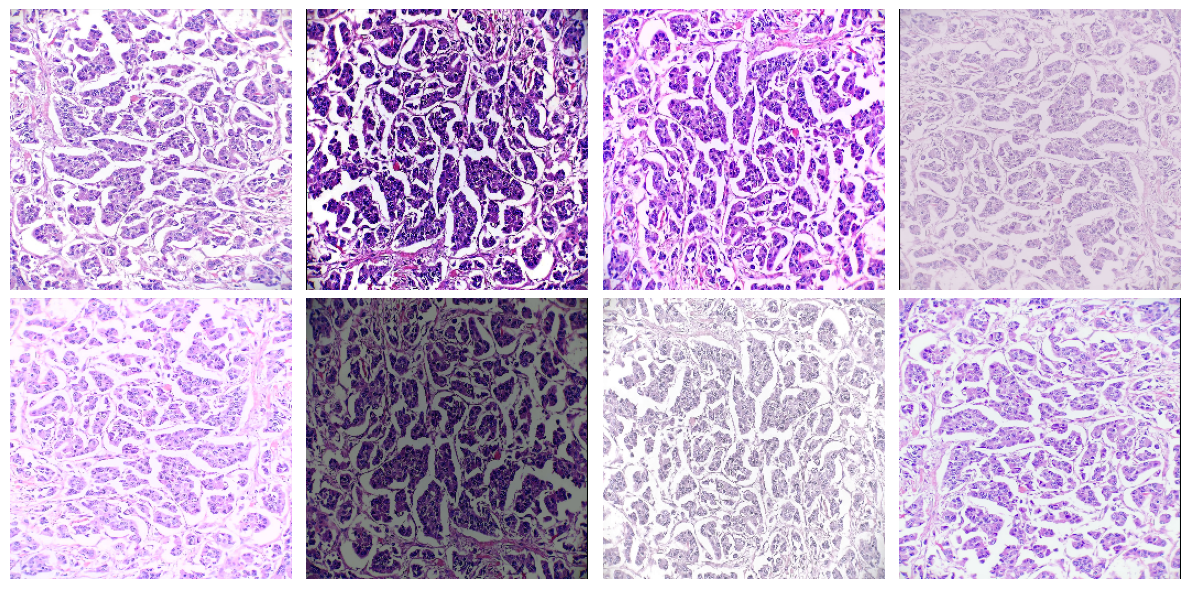

In [62]:
import matplotlib.pyplot as plt
import urllib

# Assuming you have the 'load_patch' function defined somewhere, I'm defining a placeholder for it:
def load_patch(*args):
    url_response = urllib.request.urlopen("https://indianapath.org/resources/Pictures/April%202019/4-2019-Figure%201.jpg")
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    image = cv2.imdecode(img_array, -1)
    resized_image = cv2.resize(image, (256, 256))
    return resized_image

# Test the generator with the image URL
gen = CustomDataGenerator([["dummy_address", 0, 0, 0, 0]], [0])
images, _ = gen.__getitem__(0)

# Display the results
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(cv2.cvtColor(images[i].astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()
